
# RFM Analysis

as i mentioned in EDA notebook RFM technique RFM analysis, a widely used marketing technique, relies on three crucial parameters: **Recency, Frequency, and Monetary Value**. To assess the suitability of our database for RFM analysis, we'll examine its features and characteristics.

RFM analysis categorizes customers based on Recency, Frequency, and Monetary Value. It helps businesses identify and prioritize customer segments, enabling targeted marketing strategies. This approach enhances customer engagement, satisfaction, and retention.


1. **Recency:**
   
   The dataset encompasses user interactions recorded during the years 2009, 2010, and 2011. Within this timeframe, numerous deals were captured, allowing us to examine the most recent interactions users had with our system.

2. **Frequency:**
   
   The dataset reveals a significant variation in interaction frequency. The highest number of deals for a user is 12,638, while the lowest is just one. This broad spectrum of interaction frequencies provides valuable insights into user engagement with the system.

3. **Monetary Value:**
   
   Calculating the total value each user contributed to the system involves multiplying the unit price by the quantity of items purchased and summing them up. This monetary analysis allows us to gauge the financial impact of each user on the system.


In [1]:
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np 
import seaborn as sns
import squarify


%matplotlib inline

# Data preparation

In [2]:
data = pd.read_csv("../online_retail.csv")
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data.dropna(subset=['CustomerID'], inplace=True)
data.drop_duplicates(inplace=True)
data["Quantity"] = data["Quantity"].abs() # some Quantity values are negative.
data["total_cash"] = data["Quantity"] * data["UnitPrice"]


In [3]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cash
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
condition = {"InvoiceDate": lambda x : x.max(), # recency 
             "StockCode" : "count", # frequency 
             "total_cash" : "sum"} # Monetary value

customer_data = data.groupby(by="CustomerID", as_index=False).agg(condition)

customer_data = customer_data.loc[customer_data["total_cash"] > 0]

customer_data.columns = ["customer_id", "datetime", "frequency", "monetary"]

customer_data['unix_timestamp'] = customer_data['datetime'].apply(lambda x: x.timestamp()) # to convert data of deal to unixtime
customer_data.head(3)

,customer_id,datetime,frequency,monetary,unix_timestamp
0,12346.0,2011-01-18 10:17:00,47,155164.66,1.295346e+09
1,12347.0,2011-12-07 15:52:00,222,4921.53,1.323273e+09
2,12348.0,2011-09-25 13:13:00,51,2019.40,1.316956e+09


The last recorded data is for 2011-12-09 12:50:00. We set the trash collection date ten days later, on 2011-12-19. 

The Unix time for 2011-12-19 is **1324272000**.


so for recency we calculate how many days past from 2011-12-19 

In [5]:
trashhold_date = 1324272000
customer_data["days_since_deal"] = customer_data["unix_timestamp"].apply(lambda x : np.round(((trashhold_date - x)/86400), 0) )
customer_data.head(2)

,customer_id,datetime,frequency,monetary,unix_timestamp,days_since_deal
0,12346.0,2011-01-18 10:17:00,47,155164.66,1.295346e+09,335.0
1,12347.0,2011-12-07 15:52:00,222,4921.53,1.323273e+09,12.0


In [6]:
init_frm = customer_data[["customer_id", "frequency", "monetary", "days_since_deal"]].copy()
init_frm.set_index('customer_id', inplace=True)
init_frm.head(3)

,frequency,monetary,days_since_deal
customer_id,,,
12346.0,47,155164.66,335.0
12347.0,222,4921.53,12.0
12348.0,51,2019.40,85.0


To calculate the RFM (Recency, Frequency, Monetary) score, we sum up the individual scores of recency, frequency, and monetary value. To achieve this, we first normalize the data on a scale from 0 to 1. In this normalization scheme, the customer with the lowest score receives 0, while the customer with the highest score receives 3. Therefore, we need to normalize our dataframe using scikit-learn.

## Normalization

Each parameter of RFM should be normalized to a range from 0 to 1.

In [7]:
scaler_minmax = MinMaxScaler()
scaled_init_rfm = scaler_minmax.fit_transform(init_frm)
normal_rfm = pd.DataFrame(scaled_init_rfm, columns=init_frm.columns, index=init_frm.index)


normal_rfm["days_since_deal"] = 1 - normal_rfm["days_since_deal"]

normal_rfm.head(3)

,frequency,monetary,days_since_deal
customer_id,,,
12346.0,0.003640,0.262281,0.559621
12347.0,0.017488,0.008317,0.997290
12348.0,0.003957,0.003411,0.898374


## calculate RFM score

In [8]:
normal_rfm["rfm_score"] = round(normal_rfm["frequency"] + normal_rfm["monetary"] + normal_rfm["days_since_deal"], 4)
normal_rfm.head(3)

,frequency,monetary,days_since_deal,rfm_score
customer_id,,,,
12346.0,0.003640,0.262281,0.559621,0.8255
12347.0,0.017488,0.008317,0.997290,1.0231
12348.0,0.003957,0.003411,0.898374,0.9057


## Categorize based on RFM Score

We divide our customers into four segments: **Gold, Silver, Bronze, and Tin**.

Gold: Top 25% of customers.

Silver: Middle 25% of customers.

Bronze: Lower 25% of customers.

Tin: Lowest 25% of customers.

This categorization allows us to effectively segment our customer base based on their value or importance to our business.

In [9]:
normal_rfm_sorted = normal_rfm.sort_values(by='rfm_score', ascending=False)
normal_rfm_sorted.head(3)

,frequency,monetary,days_since_deal,rfm_score
customer_id,,,,
14911.0,0.905516,0.535981,0.998645,2.4401
14646.0,0.307747,0.902415,0.998645,2.2088
17841.0,1.000000,0.118160,0.998645,2.1168


In [10]:
def segmentation(row):

    if row["rfm_score"] >=1.7:
        return "Gold"
    
    elif (row["rfm_score"] >= 1) and (row["rfm_score"] < 1.7) :
        return "Silver"
    
    elif (row["rfm_score"] >= 0.5) and (row["rfm_score"] < 1) :
        return "Bronze"
    
    elif (row["rfm_score"] >= 0) and (row["rfm_score"] < 0.5) :
        return "Tin"
    


normal_rfm_sorted['Segment'] = normal_rfm_sorted.apply(segmentation, axis=1)
normal_rfm_sorted.head(3)

,frequency,monetary,days_since_deal,rfm_score,Segment
customer_id,,,,,
14911.0,0.905516,0.535981,0.998645,2.4401,Gold
14646.0,0.307747,0.902415,0.998645,2.2088,Gold
17841.0,1.000000,0.118160,0.998645,2.1168,Gold


In [28]:
tree = normal_rfm_sorted.groupby(by="Segment", as_index=False).agg({"rfm_score":"sum"})
tree

,Segment,rfm_score
0,Bronze,2962.8473
1,Gold,10.7215
2,Silver,939.9917
3,Tin,491.3818


In [29]:

fig = go.Figure(go.Treemap(
    labels=tree["Segment"],
    parents=[None, None, None, None],
    values=tree["rfm_score"],
       
))


# Update layout
fig.update_layout(title="RFM Score Aggregated by Segment",
                  width=1400, 
                  height=800)

fig.data[0].textinfo = "label+text+value+percent root"
# Show plot
fig.show()


# Analyze customer behavior and implement new strategies accordingly.

**Champions:** These are your best customers who buy recently, frequently, and spend a lot. They are loyal, engaged, and responsive to your offers. You should reward them, retain them, and encourage referrals.
Loyal customers: These are customers who buy frequently and have a good relationship with your brand. You should reward them, upsell and cross-sell to them, and ask for feedback.

**Potential loyalists:** These are customers who have bought recently and spent a good amount, but not frequently. They have potential to become loyal customers if you nurture them and offer incentives.

**Recent customers:** These are customers who have bought only once recently. They may be first-time buyers or reactivated customers. You should provide onboarding support, follow up, and cross-sell to them.

**Promising customers:** These are customers who have bought once recently, but not spent much. They may be testing your products or services. You should offer them relevant products, discounts, and free trials to increase their engagement.
Customers needing attention: These are customers who have not bought recently, but bought frequently and spent a lot in the past. They may be at risk of churning or switching to competitors. You should re-engage them with personalized offers, feedback surveys, and loyalty programs.

**About to sleep:** These are customers who have not bought recently, frequently, or spent much. They may be inactive or uninterested in your brand. You should wake them up with reactivation campaigns, product reviews, and win-back offers.

**At risk:** These are customers who have bought frequently and spent a lot, but not recently. They may have been loyal customers before, but have stopped buying. You should try to retain them with loyalty programs, satisfaction surveys, and special offers.

**Can’t lose them:** These are customers who have bought frequently and spent a lot, but a long time ago. They may have been your best customers, but have switched to other brands. You should try to win them back with high-value offers, personal outreach, and feedback requests.

**Hibernating:** These are customers who have not bought recently, frequently, or spent much. They may have forgotten about your brand or have no need for your products or services. You should try to reawaken their interest with reactivation campaigns, product updates, and newsletters.

**Lost:** These are customers who have not bought for a long time, and have low frequency and monetary value. They may have no intention of buying from you again. You should minimize your marketing costs for them, or remove them from your database.



In [30]:
normal_rfm_sorted.head(3)

,frequency,monetary,days_since_deal,rfm_score,Segment
customer_id,,,,,
14911.0,0.905516,0.535981,0.998645,2.4401,Gold
14646.0,0.307747,0.902415,0.998645,2.2088,Gold
17841.0,1.000000,0.118160,0.998645,2.1168,Gold


In [31]:
def intercept_customer(row):
    
    if (row["frequency"] > 0.3) and (row["monetary"] > 0.5) and (row["days_since_deal"] > 0.7):
        return "Champions"
    
    elif (row["frequency"] > 0.5) and (row["monetary"] > 0.5) and (row["days_since_deal"] > 0.5):
        return "Loyal customers"
    
    elif (row["frequency"] > 0.3 ) and (row["monetary"] > 0.5) and (row["days_since_deal"] > 0.1):
        return "Potential loyalists"
    
    elif (row["frequency"] < 0.3) and (row["days_since_deal"] >= 0.5 ) : 
        return "Recent customers"
    
    elif (row["frequency"]  > 0.6) and (row["monetary"] > 0.6) and (row["days_since_deal"] < 0.3 ):
        return "Customers needing attention"
    
    elif (row["frequency"] > 0.3) and (row["monetary"] < 0.3 ) and (row["days_since_deal"] > 0.5):
        return "Promising customers"
    
    elif (row["frequency"] < 0.5 ) and (row["monetary"] < 0.5)  and (row["days_since_deal"] < 0.5 ) :
        return "About to sleep"
    
    elif (row["frequency"] < 0.3) and (row["monetary"] > 0.7) and (row["days_since_deal"] > 0.5):
        return "At risk"
    
    elif (row["frequency"] > 0.5) and (row["monetary"] > 0.5) and (row["days_since_deal"] > 0.3):
        return "Can't lose them"
    
    elif (row["frequency"] < 0.1) and (row["monetary"] > 0.7) and (row["days_since_deal"] > 0.7):
        return "Can't lose them"
    
    elif (row["frequency"] < 0.3) and (row["monetary"] < 0.3) and (row["days_since_deal"] < 0.3):
        return "Hibernating"
    
    elif (row["frequency"] < 0.1) and (row["monetary"] < 0.1) and (row["days_since_deal"] < 0.1):
        return "Lost"


In [37]:
normal_rfm_sorted["market_status"] = normal_rfm_sorted.apply(intercept_customer, axis=1)
normal_rfm_sorted.head(10)


,frequency,monetary,days_since_deal,rfm_score,Segment,market_status
customer_id,,,,,,
14911.0,0.905516,0.535981,0.998645,2.4401,Gold,Champions
14646.0,0.307747,0.902415,0.998645,2.2088,Gold,Champions
17841.0,1.000000,0.118160,0.998645,2.1168,Gold,Promising customers
18102.0,0.083010,1.000000,1.000000,2.0830,Gold,Recent customers
14156.0,0.325789,0.559187,0.987805,1.8728,Gold,Champions
12748.0,0.527103,0.101666,1.000000,1.6288,Silver,Promising customers
16446.0,0.000317,0.569564,1.000000,1.5699,Silver,Recent customers
14606.0,0.514283,0.051900,1.000000,1.5662,Silver,Promising customers
15311.0,0.362270,0.199787,1.000000,1.5621,Silver,Promising customers


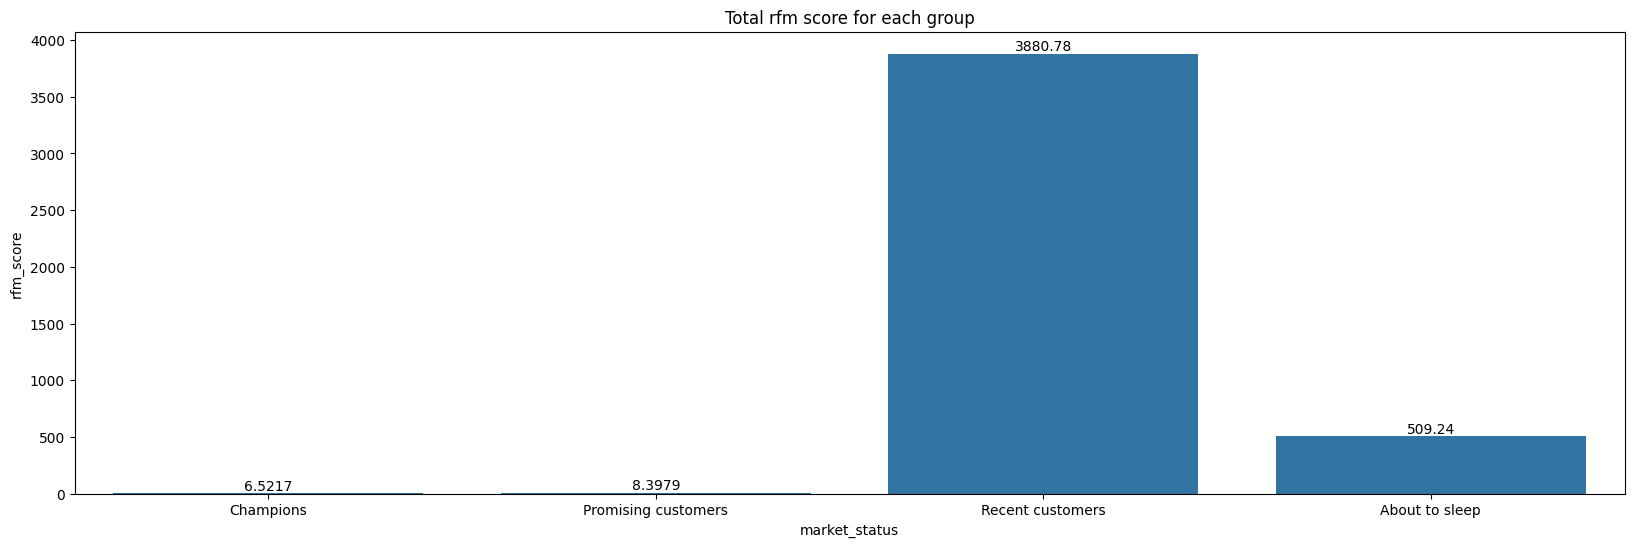

In [34]:


plt.figure(figsize=(20, 6))  
plt.title("Total rfm score for each group")
ax = sns.barplot(data=normal_rfm_sorted, x="market_status", y="rfm_score", estimator="sum",  errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()


# Clustering

In [42]:
cluster_rfm = normal_rfm_sorted.drop(columns=["Segment", "rfm_score", "market_status"])
cluster_rfm.head(2)


,frequency,monetary,days_since_deal
customer_id,,,
14911.0,0.905516,0.535981,0.998645
14646.0,0.307747,0.902415,0.998645


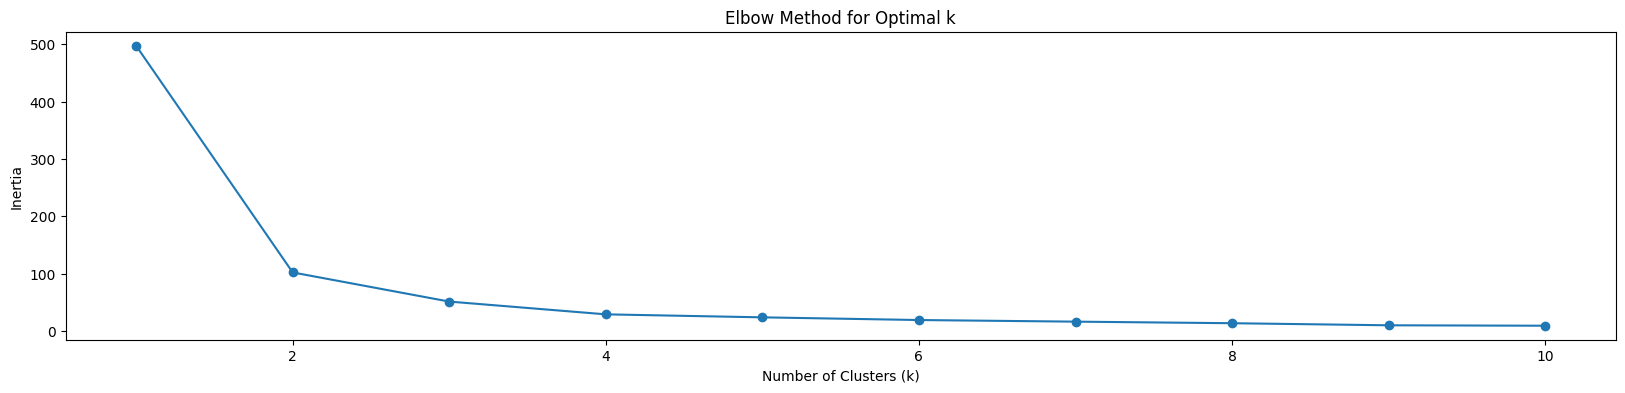

In [43]:
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(cluster_rfm)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize = (20,4))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [44]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster_rfm)
cluster_rfm["Clusters"] = (kmeans.labels_ + 1).astype(str)

In [45]:
cluster_rfm.head(3)

,frequency,monetary,days_since_deal,Clusters
customer_id,,,,
14911.0,0.905516,0.535981,0.998645,1
14646.0,0.307747,0.902415,0.998645,1
17841.0,1.000000,0.118160,0.998645,1


In [46]:
fig = px.scatter_3d(cluster_rfm, x='frequency', y='days_since_deal', z='monetary',color='Clusters')
fig.update_layout(width=1200, height=1000, 
                  scene=dict(xaxis=dict(title='Frequency', tickfont=dict(size=12)),
                 yaxis=dict(title='Days Since Deal', tickfont=dict(size=12)), 
                 zaxis=dict(title='Monetary', tickfont=dict(size=12))))

# customer classification base for each cluster


In [48]:
normal_rfm_sorted["Clusters"] = cluster_rfm["Clusters"] 
normal_rfm_sorted.head(3)

,frequency,monetary,days_since_deal,rfm_score,Segment,market_status,Clusters
customer_id,,,,,,,
14911.0,0.905516,0.535981,0.998645,2.4401,Gold,Champions,1
14646.0,0.307747,0.902415,0.998645,2.2088,Gold,Champions,1
17841.0,1.000000,0.118160,0.998645,2.1168,Gold,Promising customers,1


In [49]:
fig = px.treemap(normal_rfm_sorted, path=[px.Constant("all"), 'Clusters', 'Segment', 'market_status'], values='rfm_score')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.data[0].textinfo = "label+text+value+percent root"
fig.show()


# conclusion  

So far, I've identified:

The general behavior of each customer.
I categorized the overall customer behavior using three different methods.
Now it's time to thoroughly examine all the charts and data in a comprehensive report. Based on the insights gained from analyzing these, we'll propose various strategies for each customer segment.